In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mplc

filename_snapshot = "Dataset/snapshots_arabia_t_5040.csv"
filename_overview = "Dataset/aoe_data.csv"

In [ ]:
data        = pd.read_csv(filename_snapshot)
print("Loaded data")

overview    = pd.read_csv(filename_overview)
print("Loaded overview", )

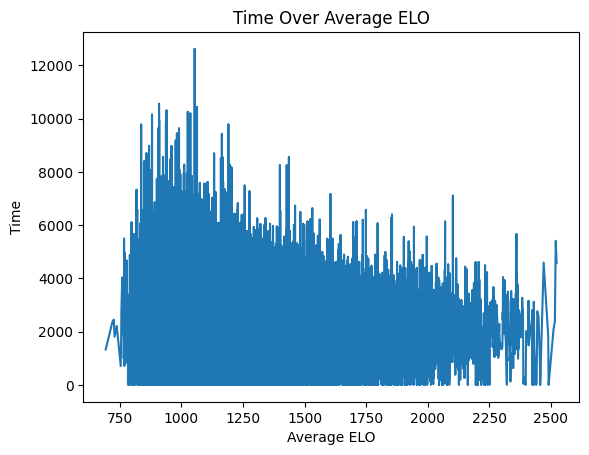

In [6]:
plt.figure()
plt.title("Time Over Average ELO")
plt.xlabel("Average ELO")
plt.ylabel("Time")

data_x = data["avg_elo"]
data_y = data["duration"]
data_order = np.argsort(data_x)
plt.plot(data_x[data_order], data_y[data_order])

plt.show()

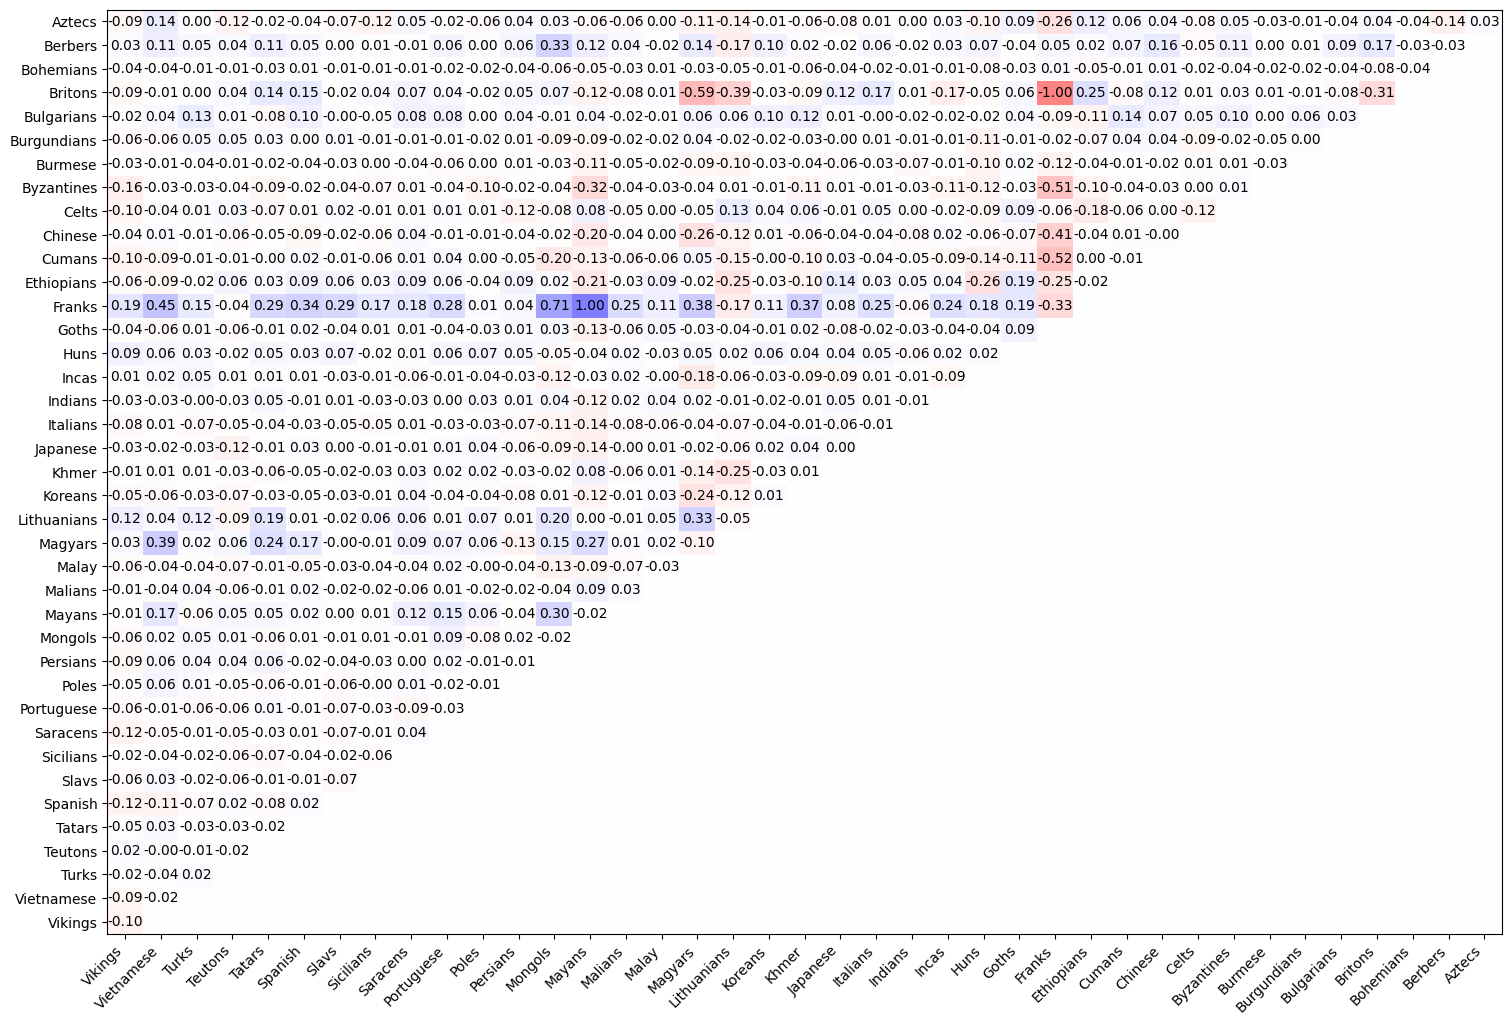

In [146]:
data_x = data["p1_civ"]
data_y = data["p2_civ"]

data_win = data["winner"]

unique_civs = []

for x in data_x:
    if x not in unique_civs:
        unique_civs.append(x)

civ_play_count = np.zeros((len(unique_civs)))


for i, x in enumerate(data_x):
    civ_play_count[unique_civs.index(x)] += 1

for i, x in enumerate(data_y):
    civ_play_count[unique_civs.index(x)] += 1

# for i, x in enumerate(unique_civs):
#     print(str(x)  + " - " + str(civ_play_count[i]))

unique_civs = sorted(unique_civs)
civ_count = len(unique_civs)
heat_grid = np.zeros((civ_count, civ_count))

for i, x in enumerate(data_x):
    civ_index = unique_civs.index(x)
    opp_index = unique_civs.index(data_y[i])
    win = data_win[i] == 0
    if opp_index < civ_index:
        temp = civ_index
        civ_index = opp_index
        opp_index = temp
        win = not win
    heat_grid[civ_index][len(unique_civs)-opp_index-1] += (1 if win else -1)

value_min = np.min(heat_grid)
value_max = np.max(heat_grid)
value_greater = max(value_min, value_max)

plt.figure(figsize=(18, 12))
plt.imshow(heat_grid, aspect="auto", cmap="bwr_r", clim=(-value_greater * 2, value_greater * 2))
plt.xticks(np.arange(civ_count), labels=np.flip(unique_civs), rotation=45, ha='right')
plt.yticks(np.arange(civ_count), labels=unique_civs)

for i in range(civ_count):
    for j in range(civ_count):
        if i <= (civ_count - j - 1):
            value = (heat_grid[i, j] - value_min) / (value_max - value_min) * 2 - 1
            plt.text(j, i, "{:.2f}".format(value),
                ha="center", va="center", color="black")

plt.show()

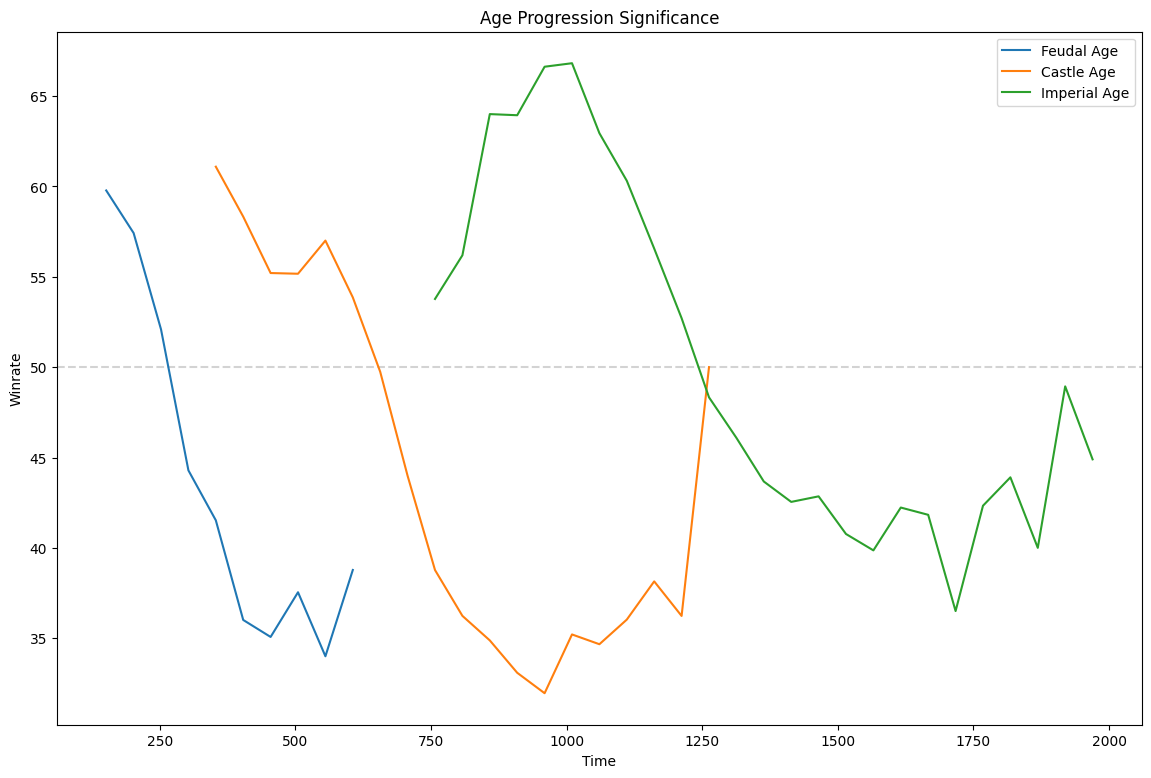

In [64]:
data_win = data["winner"]
data_times = [
    [
        data["p1 Feudal Age Time"],
        data["p1 Castle Age Time"],
        data["p1 Imperial Age Time"]
    ],
    [
        data["p2 Feudal Age Time"],
        data["p2 Castle Age Time"],
        data["p2 Imperial Age Time"]
    ]
]

data_x = np.linspace(0, 5000, 100)

wins    = np.zeros((3, 100))
losses  = np.zeros((3, 100))

for i, winner in enumerate(data_win):
    for j in range(0, 2):
        t = data_times[j]
        for k, age in enumerate(t):
            time = age[i]
            bucket = (time + 50) // 100
            if bucket >= 100 or bucket < 0:
                continue
            (wins if (winner == j) else losses)[k][bucket] += 1

data_y = [[], [], []]
for i in range(3):
    for j in range(100):
        w = wins[i][j]
        l = losses[i][j]
        if j == 0 or w < 20 or l < 20:
            data_y[i].append(float('nan'))
            continue
        winrate = (w / (w + l)) * 100
        data_y[i].append(winrate)
        
plt.figure(figsize=(14, 9))
plt.title("Age Progression Significance")
plt.xlabel("Time")
plt.ylabel("Winrate")

plt.axhline(50, color="lightgrey", ls="--")

plt.plot(data_x, data_y[0], label="Feudal Age")
plt.plot(data_x, data_y[1], label="Castle Age")
plt.plot(data_x, data_y[2], label="Imperial Age")

plt.legend(loc='upper right')

plt.show()